# Automated change detection and severity mapping using Digital Earth Australia - Worked example including technical details

This script shows the workflow for change detection and severity mapping using the DEA Landsat data archive and the burn mapping tools developed by ANU. This notebook also provides details on the underlying concepts and theory.

## Retrieve imagery from the DEA

To illustrate the concepts used in this toolbox, we first need to load in a time series of Landsat imagery.
To that end, we'll import the **BurnCube**.

In [1]:
%matplotlib inline
from BurnCube import BurnCube 
bc = BurnCube()

We will use the `load_cube` function to extract Landsat data from the DEA and mask out cloud pixels
The function takes several arguments:
    
    x: region in the x dimension (easting, EPSG 3577)
    y: region in the y dimension (northing, EPSG 3577)
    time: temporal extent
    resolution: spatial resolution in m
    landsat_numbers: Landsat sensors to be considered in list format, e.g. [5,7,8] or [8]

Standard settings are:
* projection is EPSG:3577 (GDA94 / Australian Albers). 
* product retrieved is `Landsat*\_nbart_albers`
* dates with less than 20% good-quality pixels for the region of interest will be ignored.

These settings can not be changed through arguments but can be changed in the `load_cube` function in `BurnCube.py`.

The example below will load imagery for  
* 25 km by 25 km area 
* centered around provided latitude and longitude coordinates
* at 25 m resolution 
* for a period defined by a start and end date (in `'yyyy-mm-dd'` string format)
* with burn mapping to be undertaken for the last year of this time series.

Note:
* Latitude and longitude can be converted to GDA94 using the `Proj` function in the **prypoj** module.
* Choosing a different resolution will require resampling and may increase processing time significantly.
* Similarly, imagey can be requested in different coordinates but this, too, will increase processing time.



In [2]:
import pyproj

# provide center coordinates (longitude and latitude) 
# example relates to the Sir Ivan fire in 2017 around Uarbry in NSW
lon =  148.1
lat = -41.2

# convert to projected centre coordinates
wgs84 = pyproj.Proj(init='epsg:4326')
gda94 = pyproj.Proj(init='epsg:3577')
easting,northing = pyproj.transform(wgs84,gda94,lon,lat)

# define projected region extent
x = (easting+12500,easting-12500)   # 12,500 m is half of the required window size
y = (northing+12500,northing-12500)
res = (25, 25)  # resolution
sensor = [8]  # Landsat-8

datatime = ('2013-01-01','2017-12-31') # period for extracting landsat data

bc.load_cube(x, y, res, datatime, sensor) # return time series of good-quality imagery as 4D array with [band, time, y, x]


In [3]:
print(bc.dataset) 

<xarray.Dataset>
Dimensions:  (band: 6, time: 68, x: 1001, y: 1001)
Coordinates:
  * band     (band) <U5 'red' 'green' 'blue' 'nir' 'swir1' 'swir2'
  * time     (time) datetime64[ns] 2013-05-20T23:53:55 2013-06-21T23:53:48 ...
  * y        (y) float64 -4.604e+06 -4.604e+06 -4.604e+06 -4.604e+06 ...
  * x        (x) float64 1.363e+06 1.363e+06 1.363e+06 1.364e+06 1.364e+06 ...
Data variables:
    cube     (band, time, y, x) int16 79 66 49 70 85 100 111 111 104 84 90 ...
Attributes:
    crs:      EPSG:3577


## Reflectance data check
Below follows a code snippet to visualise some part of the data. This example shows NIR reflectance (band 3) for available images during the months before and after the fire.

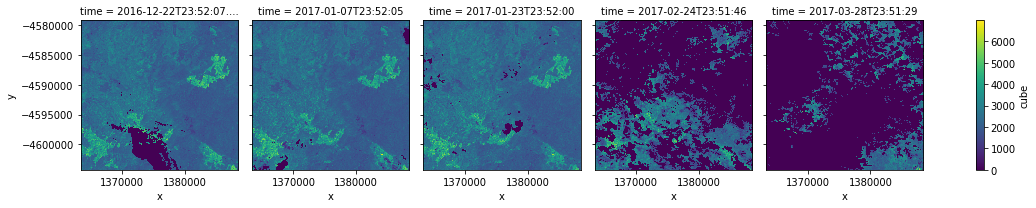

In [4]:
bc.dataset.cube.sel(time=slice('2016-12-01','2017-04-01'))[3,:,:,:].plot.imshow(col='time',col_wrap = 5)

## Calculation of the Normalized Burn Ratio (NBR)
The Normalized Burn Ratio (NBR) is recommended for use in conjunction with the cosine distance to correctly identify significant reflectance changes that can be associated with fire events. 
NBR is calculated as:

$NBR = \frac{nir-swir2}{nir+swir2}$

where _nir_ and _swir2_ refer to the Near Infrared (~840 nm) and Shortwave Infrared (~2200 nm) bands in the Landsat imagery.  

Some example NBR maps are shown below. Low NBR values (which can be indicative of burning) are shown in blueish colours and high NBR values in reddish colours. White areas indicate pixels with data of insufficient quality.

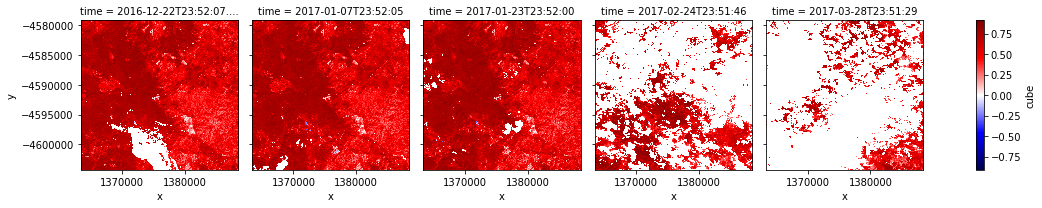

In [5]:
# example calculation of NBR
NBR = (bc.dataset.cube[3,:,:,:]-bc.dataset.cube[5,:,:,:])/(bc.dataset.cube[3,:,:,:]+bc.dataset.cube[5,:,:,:])

# plot NBR maps for a selected period
NBR.sel(time=slice('2016-12-01','2017-04-01')).plot.imshow(col='time',col_wrap = 5,cmap='seismic')

## Calculation of geometric median  and cosine and euclidian distances

We will use the `geomedian` function in the **BurnCube** module to calculate geometric median for a reference period. 
Subsequently, we will use the `distances` function in the **BurnCube** module to calculate the cosine distance and NBR Euclidean distance. 


The function `geomedian` returns the __geometric median__ of band reflectances for the reflectance datacube provided as  (Roberts *et al.*, 2017):

$\hat{m}: = argmin\sum_{i=1}^{n}\parallel x-x_i\parallel_2$, $x\in \mathbb{R}^p$

The function involves an iterative optimiser to find a numerical solution. The optimisation parameters can be configured, and the function supports distributed use of multiple CPUs for faster evaluation. Arguments are:

    period: the period for which the geomedian is to be calculated, in format ('yyyy-mm-dd','yyy-mm-dd')
    max_iter: maximum number of iterations 
    epsilon: tolerance stopping criterion    
    n_procs: number of CPUs to be used 


The function `distances` returns two standardised distances as follows:

The returned variable `cosdistance` is the __cosine distance__ between two spectra, _x_ and _y_, _i.e._, the reflectance time series data and the geometric median reflectance :

$cosdist = 1-\frac{\sum_{i=1}^{p}x_iy_i}{\sqrt{\sum_{i=1}^{p}x_i^2\sum_{i=1}^{p}y_i^2}}$

where _p_ is the number of bands. The denominator is equivalent to the 'spectral angle'.

The returned variable `nbr_eucdistance` is the __Euclidean distance in NBR space__ between the NBR time series and the median NBR (_NBRmed_) calculated from the geometric median:

$NBRdist = \sqrt{\sum_{i=1}^{n}(NBR_i-NBRmed)^2}$

where _n_ is the number of dates with imagery.
The function supports distributed use of multiple CPUs for faster evaluation. Arguments are:

    period: the period for which the distances are to be calculated, in format ('yyyy-mm-dd','yyy-mm-dd')
    n_procs: number of CPUs to be used

Use `help(function)` for  details on the usage of each function, as follows: 

In [6]:
help(bc.geomedian)
help(bc.distances)

Help on method geomedian in module BurnCube:

geomedian(period, n_procs=4, epsilon=0.5, max_iter=40) method of BurnCube.BurnCube instance
    Calculates the geometric median of band reflectances in parallel
    The procedure stops when either the error 'epsilon' or the maximum
    number of iterations 'max_iter' is reached.
        Note:
            This method saves the result of the computation into the
            self.geomed variable: p-dimensional vector with geometric
            median reflectances, where p is the number of bands.
        Args:
            period: range of dates to compute the geomedian
            n_procs: tolerance criterion to stop iteration
            epsilon: tolerance criterion to stop iteration
            max_iter: maximum number of iterations

Help on method distances in module BurnCube:

distances(period, n_procs=4) method of BurnCube.BurnCube instance
    Calculates the cosine distance between observation and reference.
    The calculation is point b

### Example calculation: geometric median
The following example shows the calculation of the geometric median using 8 CPUs. 

In [6]:
period = ('2013-01-01','2016-12-31') # period used for the calculation of geometric median
bc.geomedian(period, n_procs=8) # this typically may take around 5 minutes for a region of 1000x1000 pixels

The geomedian is stored in a new attribute `geomed`: 

In [7]:
bc.geomed

<xarray.Dataset>
Dimensions:    (band: 6, time: 52, x: 1001, y: 1001)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-20T23:53:55 2013-06-21T23:53:48 ...
  * y          (y) float64 -4.604e+06 -4.604e+06 -4.604e+06 -4.604e+06 ...
  * x          (x) float64 1.363e+06 1.363e+06 1.363e+06 1.364e+06 1.364e+06 ...
  * band       (band) <U5 'red' 'green' 'blue' 'nir' 'swir1' 'swir2'
Data variables:
    geomedian  (band, y, x) float32 185.005 146.165 117.346 151.599 154.877 ...
Attributes:
    crs:      EPSG:3577

### Visualisation of geomedian
The following code generates an RGB composite with geometric median reflectances stretched the reflectance value to [0,255] using the internal function `stretch_RGB`: 

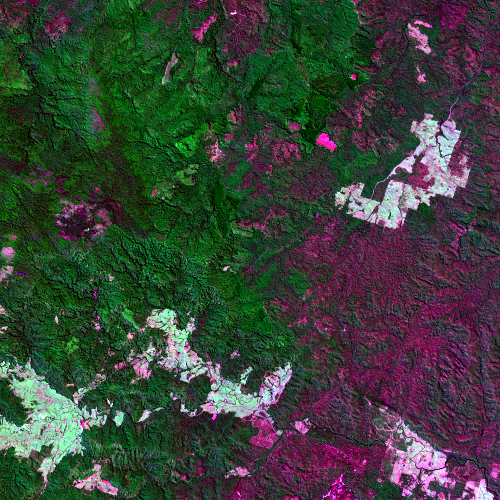

In [8]:
def stretch_RGB(data):
    """
    stretch RGB to 0-1
    """
    import numpy as np
    tmp = data
    a = (tmp-np.nanpercentile(tmp,1))/(np.nanpercentile(tmp,99.5)-np.nanpercentile(tmp,0.5))*255 
    a[a>255]=255
    a[a<0]=0
    return a

def RGB_plot(R, G, B):
    import numpy as np
    from PIL import Image   
    rgbArray = np.zeros((R.shape[0],R.shape[1],3), 'uint8')
    rgbArray[..., 0] = (stretch_RGB(R))
    rgbArray[..., 1] = (stretch_RGB(G))
    rgbArray[..., 2] = (stretch_RGB(B))
    img = Image.fromarray(np.flipud(rgbArray))
    return img.resize((500,500))

#plot the geometric median reflectances as false colour composite: swir2, nir and green as R,G,B
RGB_plot(bc.geomed.geomedian.data[5,:,:],bc.geomed.geomedian.data[3,:,:],bc.geomed.geomedian.data[1,:,:])


### Example: calculating cosine distance and euclidian distances
The following example shows the calculation of the distances together using 8 CPUs for the reference period.

In [9]:
bc.distances(period, n_procs=8) # This step can take several minutes.

The cosine and Euclidian distances are stored along with actual NBR and NBR change direction in the attribute `bc.dists`:

In [10]:
bc.dists 

<xarray.Dataset>
Dimensions:    (band: 6, time: 52, x: 1001, y: 1001)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-20T23:53:55 2013-06-21T23:53:48 ...
  * y          (y) float64 -4.604e+06 -4.604e+06 -4.604e+06 -4.604e+06 ...
  * x          (x) float64 1.363e+06 1.363e+06 1.363e+06 1.364e+06 1.364e+06 ...
  * band       (band) <U5 'red' 'green' 'blue' 'nir' 'swir1' 'swir2'
Data variables:
    cosdist    (time, y, x) float32 0.00297278 0.00160831 0.00111526 ...
    NBRDist    (time, y, x) float32 0.0336878 0.0237052 0.0463788 0.0181961 ...
    ChangeDir  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    NBR        (time, y, x) float32 0.764879 0.793911 0.820037 0.762803 ...
Attributes:
    crs:      EPSG:3577

## Outlier mapping
Having calculated the cosine and NBR euclidian distance, we can calculate a distance _d_ for every pixel that corresponds to the threshold distance for an outlier. 
We the use quartile-based outlier criterion commonly used in box-and-whiskers plots, among others (Tukey, 1977): 

$ d > Q_{3}+1.5*{IQR} = Q_{3}+1.5(Q_{3}-Q_{1})$

where $Q_1$ and $Q_3$ are the 1st and 3rd quartile (or 25th and 75th percentile), and _IQR_ is the interquartile range.  


In [11]:
bc.outliers()

The distance functions and outlier detection functions only need to be evaluated once for a given period and region of interest. The following examples show maps of the threshold values for `cosdist` and `nbr_ecudistance`.

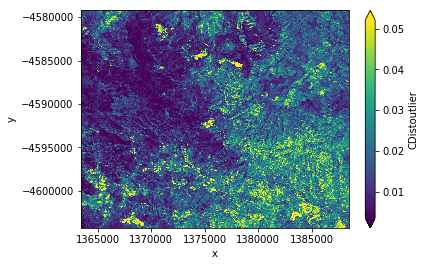

In [12]:
bc.outlrs.CDistoutlier.plot.imshow(robust=True)

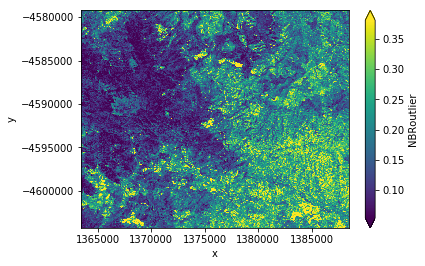

In [13]:
bc.outlrs.NBRoutlier.plot.imshow(robust=True)

## Burn severity mapping

The function `severitymapping` from the **BurnCube** module is designed to map the extent and severity of likely burns. Outputs include two classes for burned area, namely high severity and moderate severity burns.

Two methods are available for change and severity mapping using the difference thresholding scheme:

1. `NBR` method: detects cosine distance outliers and requires that dNBR<0. Suitable for burn detection.Recommended for burn detection.

2. `NBRdist` method: detects cosine distance outliers and NBR euclidean distance outliers, and requires a reduction in NBR. This method can detect more area with moderate burn.

The default method is `NBR`. All pixels detected as burned area following this method are classified as 'high-severity' burns.

An optional, and recommended, extension to the method is region-growing. This will include further areas that do not qualify as outliers but do show a substantial decrease in NBR and are adjoining pixels detected as burns. These pixels are classified as 'moderate severity burns'.

Detected fire events derived from GA Sentinel Hotspots are used to provide *corroborating evidence* to confirm potential burn areas detected from the spectral observations. A buffer of 4-km wide is drawn around the detected fire location, to account for positional inaccuracies and the possibility that the fire may have spread before and after detection. 

Arguments of the function are:

    mappingperiod: the period for which the geomedian is to be calculated, in format ('yyyy-mm-dd','yyy-mm-dd')
    method: the method to be used ('NBR' or 'NBRdist') 
    growing: whether to extend the burn area mapping using region-growing (False/True)    

The following example generates a burn severity map using the method 'NBR'.

In [14]:
mappingperiod = ('2016-07-01','2017-06-30')
bc.distances(mappingperiod,n_procs=8)
out = bc.severitymapping(mappingperiod, method='NBR',growing=True) 

No hotspots data found.
No hotspots data.


In [15]:
out

<xarray.Dataset>
Dimensions:    (x: 1001, y: 1001)
Coordinates:
  * y          (y) float64 -4.604e+06 -4.604e+06 -4.604e+06 -4.604e+06 ...
  * x          (x) float64 1.363e+06 1.363e+06 1.363e+06 1.364e+06 1.364e+06 ...
Data variables:
    StartDate  (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Duration   (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    Severity   (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Severe     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    Moderate   (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577

Save the data to a NetCDF file using `out.to_netcdf`:

In [16]:
#save the output in netCDF
out.to_netcdf('/home/554/lm4502/burn-mapping-master/BurnMapping_test_goshen2.nc')

The code snippet below illustrates the respective areas classified as high-intensity burns only, moderate- or high-intensity burns, and areas for which corroborating evidence for burning exists from Sentinel Hotspots. 
The fourth figure shows the simple sum of the previous three binary images. 

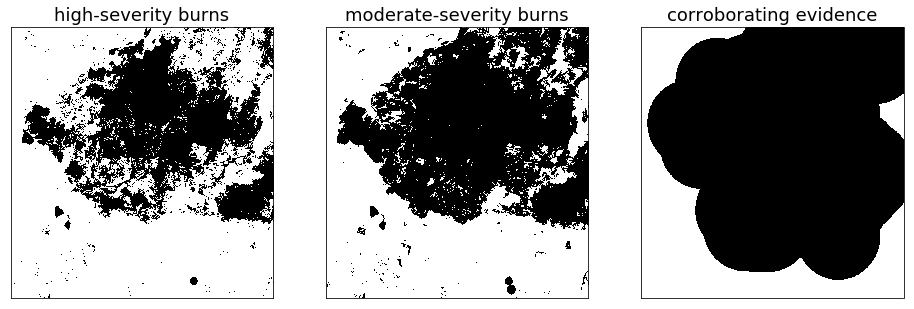

In [18]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(ncols=3,figsize=[16,5])
#plot the high-severity burns 
cax1=out.Severe.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
cax1.axes.set_title('high-severity burns',fontsize=18)
cax1.axes.get_xaxis().set_visible(False)
cax1.axes.get_yaxis().set_visible(False)
#plot the moderate severity burns
cax2=out.Moderate.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False)
cax2.axes.set_title('moderate-severity burns',fontsize=18)
cax2.axes.get_xaxis().set_visible(False)
cax2.axes.get_yaxis().set_visible(False)
#plot corroborating evidence from hotspots data
cax3=out.Corroborate.plot.imshow(ax=axes[2],cmap='binary',add_colorbar=False)
cax3.axes.set_title('corroborating evidence',fontsize=18)
cax3.axes.get_xaxis().set_visible(False)
cax3.axes.get_yaxis().set_visible(False)

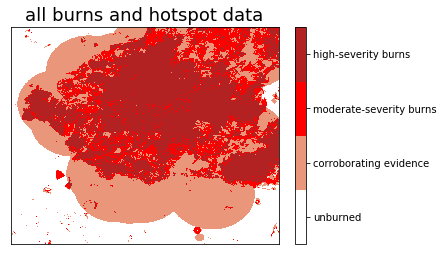

In [19]:
#plot both high and moderate burns with the hotspot data
Allburnt = out.Severe+out.Moderate+out.Corroborate
from matplotlib.colors import ListedColormap
fig,axes=plt.subplots()
cMap = ListedColormap(['white','darksalmon','red','firebrick'])
cax=Allburnt.plot.imshow(cmap=cMap,levels=[0,1,2,3,4],add_colorbar=False)
cax.axes.set_title('all burns and hotspot data',fontsize=18)
cbar = fig.colorbar(cax,ticks=[0.5,1.5,2.5,3.5])
cbar.ax.set_yticklabels(['unburned','corroborating evidence','moderate-severity burns','high-severity burns'])
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)

A comparison of the four panels shows there are areas 
* detected as burned but apparently well away from other mapped burn areas and without corroborating evidence from detected fires
* detected as burned that are more than 4-km away from detected fires but that adjoing corroborated burn areas.

An example of how to validate severity mapping is included in the notebook `Validation_example1.ipynb`